# Testing the signal quality with Alphalens

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
import pandas as pd
import seaborn as sns

from alphalens.tears import (create_summary_tear_sheet,
                             create_full_tear_sheet)

from alphalens.utils import get_clean_factor_and_forward_returns

In [3]:
sns.set_style('whitegrid')

In [4]:
idx = pd.IndexSlice

In [5]:
results_path = Path('results', 'return_predictions')
if not results_path.exists():
    results_path.mkdir(parents=True)

## Evaluating the Cross-Validation Results

In [6]:
lookahead = 1

In [7]:
cv_store = Path(results_path / 'parameter_tuning.h5')

### Get AlphaLens Input

In [13]:
DATA_DIR = Path('..', 'data')

Using next available prices.

In [14]:
def get_trade_prices(tickers):
    store = DATA_DIR / 'assets.h5'
    prices = pd.read_hdf(store, 'stooq/jp/tse/stocks/prices')
    return (prices.loc[idx[tickers, '2014': '2019'], 'open']
            .unstack('ticker')
            .sort_index()
            .shift(-1)
            .dropna()
            .tz_localize('UTC'))

Reloading predictions.

In [10]:
best_predictions = pd.read_hdf(results_path / 'predictions.h5', f'test/{lookahead:02}')
best_predictions.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 948528 entries, ('1332.JP', Timestamp('2019-11-29 00:00:00')) to ('9990.JP', Timestamp('2018-01-05 00:00:00'))
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       948528 non-null  float64
 1   1       948528 non-null  float64
 2   2       948528 non-null  float64
 3   3       948528 non-null  float64
 4   4       948528 non-null  float64
 5   5       948528 non-null  float64
 6   6       948528 non-null  float64
 7   7       948528 non-null  float64
 8   8       948528 non-null  float64
 9   9       948528 non-null  float64
dtypes: float64(10)
memory usage: 76.1+ MB


In [ ]:
test_tickers = best_predictions.index.get_level_values('ticker').unique()

In [15]:
trade_prices = get_trade_prices(test_tickers)
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1464 entries, 2014-01-06 00:00:00+00:00 to 2019-12-27 00:00:00+00:00
Columns: 941 entries, 1332.JP to 9990.JP
dtypes: float64(941)
memory usage: 10.5 MB


In [11]:
factor = (best_predictions
          .iloc[:, :3]
          .mean(1)
          .tz_localize('UTC', level='date')
          .swaplevel()
          .dropna()
          .reset_index()
          .drop_duplicates()
          .set_index(['date', 'ticker']))

In [16]:
factor_data = get_clean_factor_and_forward_returns(factor=factor,
                                                   prices=trade_prices,
                                                   quantiles=5,
                                                   periods=(1, 5, 10, 21))
factor_data.sort_index().info()

Dropped 4.2% entries from factor data: 4.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 454503 entries, (Timestamp('2017-12-05 00:00:00+0000', tz='UTC'), '1332.JP') to (Timestamp('2019-11-28 00:00:00+0000', tz='UTC'), '9990.JP')
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   1D               454503 non-null  float64
 1   5D               454503 non-null  float64
 2   10D              454503 non-null  float64
 3   21D              454503 non-null  float64
 4   factor           454503 non-null  float64
 5   factor_quantile  454503 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 22.6+ MB


### Summary Tearsheet

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.017367,0.012132,-0.000227,0.002643,91727,20.181825
2,-0.014231,0.012997,0.000088,0.002403,90718,19.959824
3,-0.013908,0.013299,0.000283,0.002350,90905,20.000968
4,-0.013452,0.015523,0.000569,0.002428,90535,19.919560
5,-0.013128,0.024762,0.001552,0.003033,90618,19.937822


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,0.011,0.035,0.041,0.026
beta,0.116,0.095,0.076,0.058
Mean Period Wise Return Top Quantile (bps),1.094,1.171,1.383,1.100
Mean Period Wise Return Bottom Quantile (bps),-1.027,-1.708,-1.594,-1.073
Mean Period Wise Spread (bps),2.120,2.864,2.963,2.158


Information Analysis


,1D,5D,10D,21D
IC Mean,0.004,0.014,0.020,0.015
IC Std.,0.125,0.130,0.128,0.126
Risk-Adjusted IC,0.034,0.107,0.153,0.121
t-stat(IC),0.737,2.344,3.362,2.657
p-value(IC),0.461,0.019,0.001,0.008
IC Skew,0.001,0.157,0.395,0.620
IC Kurtosis,0.920,0.047,0.349,0.568


Turnover Analysis


,1D,5D,10D,21D
Quantile 1 Mean Turnover,0.626,0.700,0.752,0.796
Quantile 2 Mean Turnover,0.712,0.751,0.773,0.788
Quantile 3 Mean Turnover,0.731,0.769,0.783,0.792
Quantile 4 Mean Turnover,0.711,0.763,0.786,0.801
Quantile 5 Mean Turnover,0.526,0.620,0.677,0.745


,1D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.392,0.26,0.159,0.041


<Figure size 432x288 with 0 Axes>

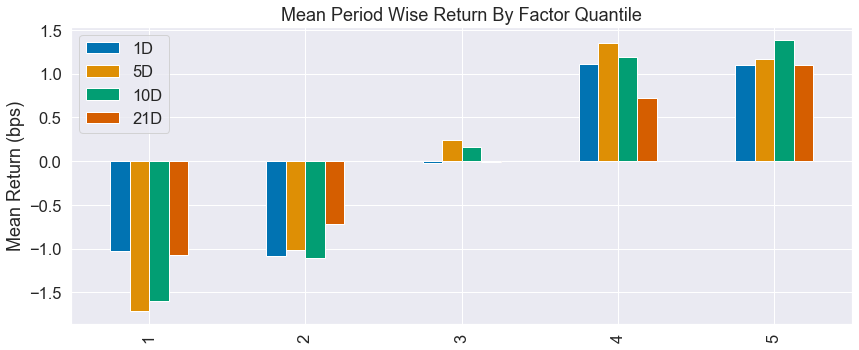

In [17]:
create_summary_tear_sheet(factor_data)

## Evaluating the Out-of-sample predictions

### Prepare Factor Data

In [18]:
t = 1
predictions = pd.read_hdf(results_path / 'predictions.h5',
                          f'test/{t:02}').drop('y_test', axis=1)

In [19]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 474264 entries, ('1332.JP', Timestamp('2019-11-29 00:00:00')) to ('9990.JP', Timestamp('2018-01-05 00:00:00'))
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       474264 non-null  float64
 1   1       474264 non-null  float64
 2   2       474264 non-null  float64
 3   3       474264 non-null  float64
 4   4       474264 non-null  float64
 5   5       474264 non-null  float64
 6   6       474264 non-null  float64
 7   7       474264 non-null  float64
 8   8       474264 non-null  float64
 9   9       474264 non-null  float64
dtypes: float64(10)
memory usage: 38.1+ MB


In [20]:
factor = (predictions.iloc[:, :10]
                   .mean(1)
                   .sort_index().tz_localize('UTC', level='date').swaplevel().dropna())
factor.head()

date                       ticker 
2017-12-05 00:00:00+00:00  1332.JP    0.000141
2017-12-06 00:00:00+00:00  1332.JP    0.003057
2017-12-07 00:00:00+00:00  1332.JP    0.000622
2017-12-08 00:00:00+00:00  1332.JP    0.000652
2017-12-11 00:00:00+00:00  1332.JP    0.002804
dtype: float64

### Select next available trade prices

Using next available prices.

In [21]:
tickers = factor.index.get_level_values('ticker').unique()
trade_prices = get_trade_prices(tickers)
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1464 entries, 2014-01-06 00:00:00+00:00 to 2019-12-27 00:00:00+00:00
Columns: 941 entries, 1332.JP to 9990.JP
dtypes: float64(941)
memory usage: 10.5 MB


### Get AlphaLens Inputs

In [22]:
factor_data = get_clean_factor_and_forward_returns(factor=factor,
                                                   prices=trade_prices,
                                                   quantiles=5,
                                                   periods=(1, 5, 10, 21))
factor_data.sort_index().info()

Dropped 4.2% entries from factor data: 4.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 454503 entries, (Timestamp('2017-12-05 00:00:00+0000', tz='UTC'), '1332.JP') to (Timestamp('2019-11-28 00:00:00+0000', tz='UTC'), '9990.JP')
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   1D               454503 non-null  float64
 1   5D               454503 non-null  float64
 2   10D              454503 non-null  float64
 3   21D              454503 non-null  float64
 4   factor           454503 non-null  float64
 5   factor_quantile  454503 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 22.6+ MB


### Summary Tearsheet

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.029615,0.011705,-0.003775,0.005519,91290,20.085676
2,-0.027110,0.012049,-0.002620,0.005339,90801,19.978086
3,-0.026902,0.019264,-0.001896,0.005392,90805,19.978966
4,-0.026794,0.020319,-0.001151,0.005475,90808,19.979626
5,-0.026460,0.024469,0.000147,0.005740,90799,19.977646


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,0.049,0.005,0.003,0.016
beta,0.022,0.019,0.014,0.016
Mean Period Wise Return Top Quantile (bps),2.918,0.569,0.256,0.915
Mean Period Wise Return Bottom Quantile (bps),-2.033,-0.118,-0.475,-0.917
Mean Period Wise Spread (bps),4.951,0.688,0.736,1.834


Information Analysis


,1D,5D,10D,21D
IC Mean,0.009,0.002,0.005,0.016
IC Std.,0.109,0.113,0.110,0.106
Risk-Adjusted IC,0.084,0.021,0.041,0.152
t-stat(IC),1.848,0.468,0.909,3.351
p-value(IC),0.065,0.640,0.364,0.001
IC Skew,0.013,0.143,0.180,0.355
IC Kurtosis,1.002,0.874,0.740,0.550


Turnover Analysis


,1D,5D,10D,21D
Quantile 1 Mean Turnover,0.714,0.745,0.779,0.798
Quantile 2 Mean Turnover,0.777,0.783,0.794,0.800
Quantile 3 Mean Turnover,0.780,0.790,0.795,0.798
Quantile 4 Mean Turnover,0.775,0.784,0.796,0.799
Quantile 5 Mean Turnover,0.708,0.737,0.778,0.798


,1D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.151,0.11,0.032,-0.006


<Figure size 432x288 with 0 Axes>

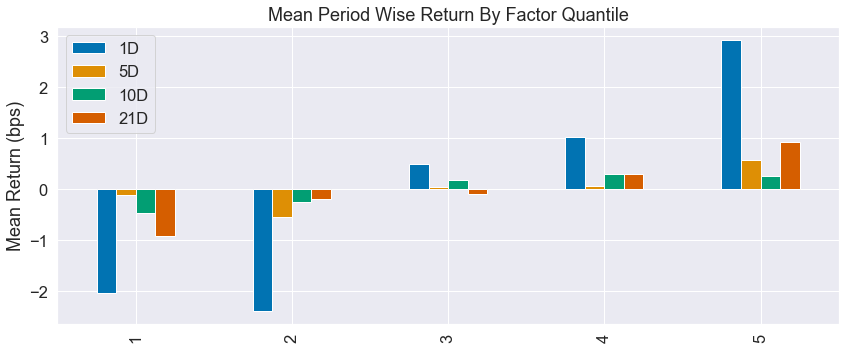

In [23]:
create_summary_tear_sheet(factor_data)